# Customer Segmentation with K-Means Clustering

This notebook demonstrates customer segmentation using K-Means clustering. It creates a synthetic dataset with customer features and applies clustering to identify distinct customer groups for targeted marketing strategies.

## Project Overview
- **Problem Type**: Unsupervised Learning - Customer Segmentation
- **Algorithm**: K-Means Clustering
- **Approach**: Feature scaling, optimal K determination, cluster analysis
- **Focus**: Business insights and targeted marketing strategies

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Generate Synthetic Customer Dataset

In [2]:
# Generate synthetic customer data with clear clustering patterns
n_customers = 800

# Create customer segments with minimal overlap
segment_size = n_customers // 4

# Ultra-Premium Customers
premium_size = segment_size
premium_annual_spending = np.random.normal(4000, 200, premium_size)  # Much higher, tighter range
premium_purchase_freq = np.random.normal(15, 2, premium_size)        # Moderate frequency
premium_age = np.random.normal(50, 5, premium_size)                  # Older, tighter range
premium_tenure = np.random.normal(48, 6, premium_size)               # Long tenure
premium_regions = np.random.choice(['North', 'East'], premium_size, p=[0.7, 0.3])  # Concentrated regions

# High-Frequency Shoppers
frequent_size = segment_size
frequent_annual_spending = np.random.normal(1800, 150, frequent_size) # Mid-high spending
frequent_purchase_freq = np.random.normal(35, 3, frequent_size)       # Very high frequency
frequent_age = np.random.normal(32, 4, frequent_size)                 # Young adults
frequent_tenure = np.random.normal(24, 4, frequent_size)              # Medium tenure
frequent_regions = np.random.choice(['South', 'West'], frequent_size, p=[0.8, 0.2])

# Moderate Stable Customers
moderate_size = segment_size
moderate_annual_spending = np.random.normal(1200, 100, moderate_size) # Moderate spending
moderate_purchase_freq = np.random.normal(12, 2, moderate_size)       # Low-moderate frequency
moderate_age = np.random.normal(42, 4, moderate_size)                 # Middle-aged
moderate_tenure = np.random.normal(36, 5, moderate_size)              # Stable tenure
moderate_regions = np.random.choice(['North', 'South', 'East', 'West'], moderate_size, p=[0.25, 0.25, 0.25, 0.25])

# Budget/Infrequent Customers
budget_size = segment_size
budget_annual_spending = np.random.normal(300, 80, budget_size)       # Very low spending
budget_purchase_freq = np.random.normal(4, 1, budget_size)            # Very low frequency
budget_age = np.random.normal(25, 3, budget_size)                     # Young, tight range
budget_tenure = np.random.normal(8, 3, budget_size)                   # Short tenure
budget_regions = np.random.choice(['West', 'South'], budget_size, p=[0.6, 0.4])

# Combine all segments
annual_spending = np.concatenate([premium_annual_spending, frequent_annual_spending, 
                                moderate_annual_spending, budget_annual_spending])
purchase_frequency = np.concatenate([premium_purchase_freq, frequent_purchase_freq, 
                                   moderate_purchase_freq, budget_purchase_freq])
age = np.concatenate([premium_age, frequent_age, moderate_age, budget_age])
tenure = np.concatenate([premium_tenure, frequent_tenure, moderate_tenure, budget_tenure])
regions = np.concatenate([premium_regions, frequent_regions, moderate_regions, budget_regions])

# Ensure realistic bounds with less overlap
annual_spending = np.clip(annual_spending, 150, 5000)
purchase_frequency = np.clip(purchase_frequency, 2, 45)
age = np.clip(age, 18, 65).astype(int)
tenure = np.clip(tenure, 1, 60).astype(int)

# Calculate derived features with clear separation
avg_order_value = annual_spending / purchase_frequency
avg_order_value = np.clip(avg_order_value, 30, 400)

# Days since last purchase - create clear patterns
days_since_last_purchase = np.concatenate([
    np.random.exponential(8, premium_size),      # Premium: recent purchases
    np.random.exponential(5, frequent_size),     # Frequent: very recent  
    np.random.exponential(12, moderate_size),    # Moderate: somewhat recent
    np.random.exponential(25, budget_size)       # Budget: older purchases
])
days_since_last_purchase = np.clip(days_since_last_purchase, 1, 120).astype(int)

# Create DataFrame
customer_data = {
    'customer_id': range(1, n_customers + 1),
    'annual_spending': annual_spending.round(2),
    'purchase_frequency': purchase_frequency.round(0).astype(int),
    'age': age,
    'region': regions,
    'tenure_months': tenure,
    'avg_order_value': avg_order_value.round(2),
    'days_since_last_purchase': days_since_last_purchase
}

df = pd.DataFrame(customer_data)

# Shuffle the data to mix the segments
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Generated dataset with {len(df)} customers")
print(f"Features: {list(df.columns)}")
print(f"\nDesigned 4 distinct segments:")
print(f"- Ultra-Premium: ~$4000 spending, age ~50, 15 purchases/year")
print(f"- High-Frequency: ~$1800 spending, age ~32, 35 purchases/year") 
print(f"- Moderate-Stable: ~$1200 spending, age ~42, 12 purchases/year")
print(f"- Budget-Infrequent: ~$300 spending, age ~25, 4 purchases/year")
df.head(10)

Generated dataset with 800 customers
Features: ['customer_id', 'annual_spending', 'purchase_frequency', 'age', 'region', 'tenure_months', 'avg_order_value', 'days_since_last_purchase']

Designed 4 distinct segments:
- Ultra-Premium: ~$4000 spending, age ~50, 15 purchases/year
- High-Frequency: ~$1800 spending, age ~32, 35 purchases/year
- Moderate-Stable: ~$1200 spending, age ~42, 12 purchases/year
- Budget-Infrequent: ~$300 spending, age ~25, 4 purchases/year


,customer_id,annual_spending,purchase_frequency,age,region,tenure_months,avg_order_value,days_since_last_purchase
0,697,167.61,3,28,West,8,52.06,8
1,668,439.79,2,24,West,7,185.66,8
2,64,3760.76,13,51,North,44,290.38,2
3,534,1118.07,13,47,South,40,87.85,5
4,67,3985.60,18,53,North,46,218.21,10
5,622,400.57,2,24,West,6,188.05,32
6,347,1909.90,35,38,South,24,54.19,10
7,491,1123.09,14,37,North,34,81.59,4
8,761,334.04,4,23,West,10,78.99,42
9,457,1122.71,16,40,West,37,69.96,1


## 3. Explore the Dataset

In [3]:
# Basic dataset information
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Statistical summary of numerical features
numerical_cols = ['annual_spending', 'purchase_frequency', 'age', 'tenure_months', 'avg_order_value', 'days_since_last_purchase']
print("\nNumerical Features Summary:")
df[numerical_cols].describe().round(2)

Dataset Info:
Shape: (800, 8)
Missing values: 0

Numerical Features Summary:


,annual_spending,purchase_frequency,age,tenure_months,avg_order_value,days_since_last_purchase
count,800.00,800.00,800.00,800.00,800.00,800.00
mean,1827.96,16.57,36.77,28.70,125.49,11.70
std,1368.78,11.64,10.14,15.44,87.71,15.28
min,150.00,2.00,18.00,1.00,30.00,1.00
25%,827.06,7.00,28.00,14.00,56.84,2.00
50%,1452.84,14.00,37.00,29.00,90.42,6.00
75%,2489.40,24.00,45.00,41.00,186.26,15.00
max,4544.03,43.00,65.00,60.00,400.00,120.00


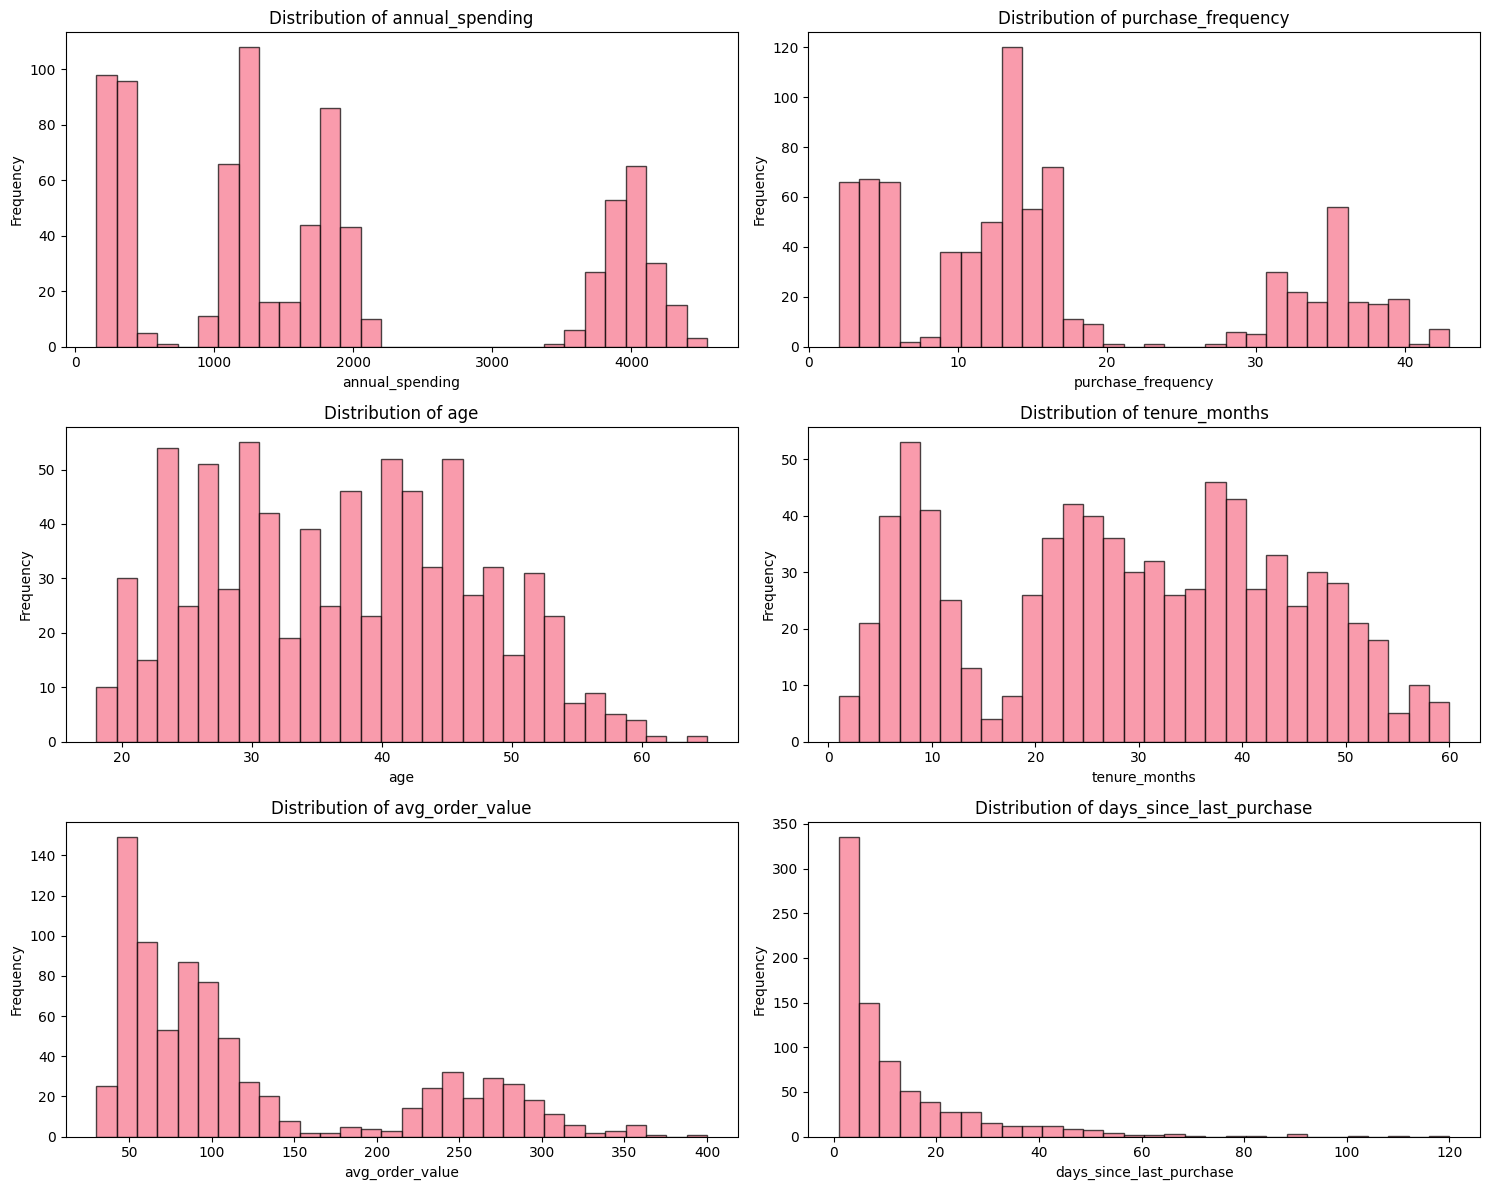

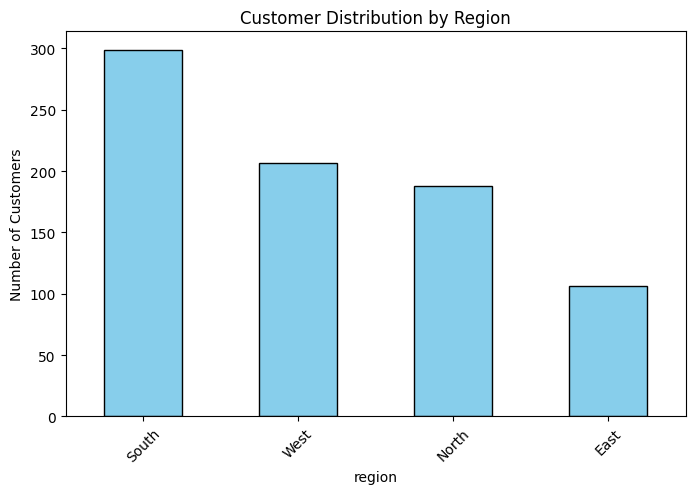

In [4]:
# Visualize feature distributions
plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)
    plt.hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Region distribution
plt.figure(figsize=(8, 5))
df['region'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Customer Distribution by Region')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

## 4. Data Preprocessing for Clustering

In [5]:
# Select features for clustering (excluding customer_id and region for now)
clustering_features = ['annual_spending', 'purchase_frequency', 'age', 'tenure_months', 'avg_order_value', 'days_since_last_purchase']
X = df[clustering_features].copy()

print(f"Features for clustering: {clustering_features}")
print(f"Clustering data shape: {X.shape}")

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeatures scaled using StandardScaler")
print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean of scaled features: {X_scaled.mean(axis=0).round(3)}")
print(f"Std of scaled features: {X_scaled.std(axis=0).round(3)}")

Features for clustering: ['annual_spending', 'purchase_frequency', 'age', 'tenure_months', 'avg_order_value', 'days_since_last_purchase']
Clustering data shape: (800, 6)

Features scaled using StandardScaler
Scaled data shape: (800, 6)
Mean of scaled features: [ 0. -0.  0. -0. -0. -0.]
Std of scaled features: [1. 1. 1. 1. 1. 1.]


## 5. Determine Optimal Number of Clusters

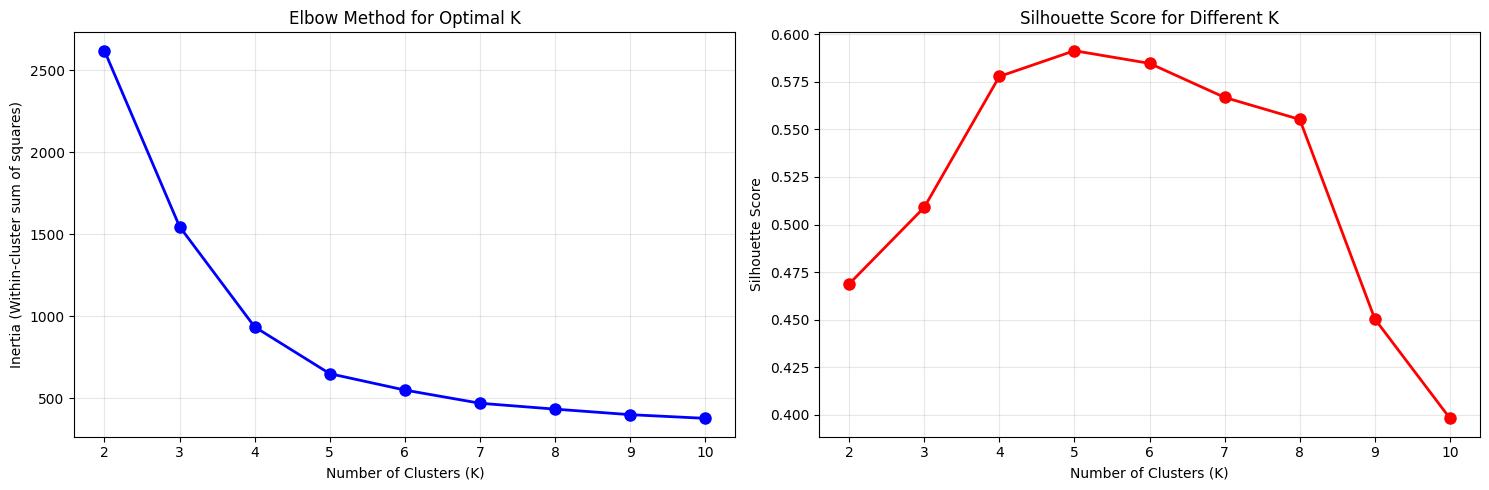

K-value analysis:
K=2: Inertia=2620.63, Silhouette Score=0.469
K=3: Inertia=1548.29, Silhouette Score=0.509
K=4: Inertia=936.39, Silhouette Score=0.578
K=5: Inertia=651.14, Silhouette Score=0.591
K=6: Inertia=551.12, Silhouette Score=0.585
K=7: Inertia=470.71, Silhouette Score=0.567
K=8: Inertia=434.83, Silhouette Score=0.555
K=9: Inertia=401.08, Silhouette Score=0.450
K=10: Inertia=378.64, Silhouette Score=0.398


In [6]:
# Elbow method to determine optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # Test K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
plt.figure(figsize=(15, 5))

# Elbow method plot
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the scores for analysis
print("K-value analysis:")
for k, inert, sil in zip(K_range, inertia, silhouette_scores):
    print(f"K={k}: Inertia={inert:.2f}, Silhouette Score={sil:.3f}")

## 6. Apply K-Means Clustering

In [7]:
# Determine optimal K from the analysis results
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
best_silhouette = max(silhouette_scores)

print(f"Analysis of K values:")
for k, inert, sil in zip(K_range, inertia, silhouette_scores):
    marker = " <- BEST" if k == best_k else ""
    print(f"K={k}: Inertia={inert:.2f}, Silhouette Score={sil:.3f}{marker}")

print(f"\nOptimal K based on silhouette analysis: {best_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")

# Use the data-driven optimal K
optimal_k = best_k

# Apply K-Means clustering with optimal K
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print(f"\nK-Means clustering completed with K={optimal_k}")
print(f"Final Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())

Analysis of K values:
K=2: Inertia=2620.63, Silhouette Score=0.469
K=3: Inertia=1548.29, Silhouette Score=0.509
K=4: Inertia=936.39, Silhouette Score=0.578
K=5: Inertia=651.14, Silhouette Score=0.591 <- BEST
K=6: Inertia=551.12, Silhouette Score=0.585
K=7: Inertia=470.71, Silhouette Score=0.567
K=8: Inertia=434.83, Silhouette Score=0.555
K=9: Inertia=401.08, Silhouette Score=0.450
K=10: Inertia=378.64, Silhouette Score=0.398

Optimal K based on silhouette analysis: 5
Best silhouette score: 0.591

K-Means clustering completed with K=5
Final Silhouette Score: 0.591

Cluster distribution:
cluster
0     51
1    193
2    200
3    200
4    156
Name: count, dtype: int64


## 7. Cluster Analysis and Characteristics

In [8]:
# Analyze cluster characteristics
cluster_summary = df.groupby('cluster')[clustering_features].mean().round(2)
print("Cluster Characteristics (Mean Values):")
print("="*60)
print(cluster_summary)

# Additional statistics for each cluster
print("\nDetailed Cluster Analysis:")
print("="*60)
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} customers):")
    print(f"  Average Annual Spending: ${cluster_data['annual_spending'].mean():.2f}")
    print(f"  Average Purchase Frequency: {cluster_data['purchase_frequency'].mean():.1f} times/year")
    print(f"  Average Age: {cluster_data['age'].mean():.1f} years")
    print(f"  Average Tenure: {cluster_data['tenure_months'].mean():.1f} months")
    print(f"  Average Order Value: ${cluster_data['avg_order_value'].mean():.2f}")
    print(f"  Days Since Last Purchase: {cluster_data['days_since_last_purchase'].mean():.1f} days")
    print(f"  Most common region: {cluster_data['region'].mode().iloc[0]}")

Cluster Characteristics (Mean Values):
         annual_spending  purchase_frequency    age  tenure_months  \
cluster                                                              
0                 414.56                5.08  27.14          11.76   
1                1199.80               12.05  41.41          35.89   
2                1821.13               35.06  31.95          23.82   
3                3991.85               15.16  49.06          47.48   
4                 301.70                4.01  24.59           7.53   

         avg_order_value  days_since_last_purchase  
cluster                                             
0                  82.49                     56.08  
1                 102.01                     10.46  
2                  52.35                      4.54  
3                 267.34                      7.27  
4                  80.51                     13.59  

Detailed Cluster Analysis:

Cluster 0 (51 customers):
  Average Annual Spending: $414.56
  Average

## 8. Cluster Visualizations

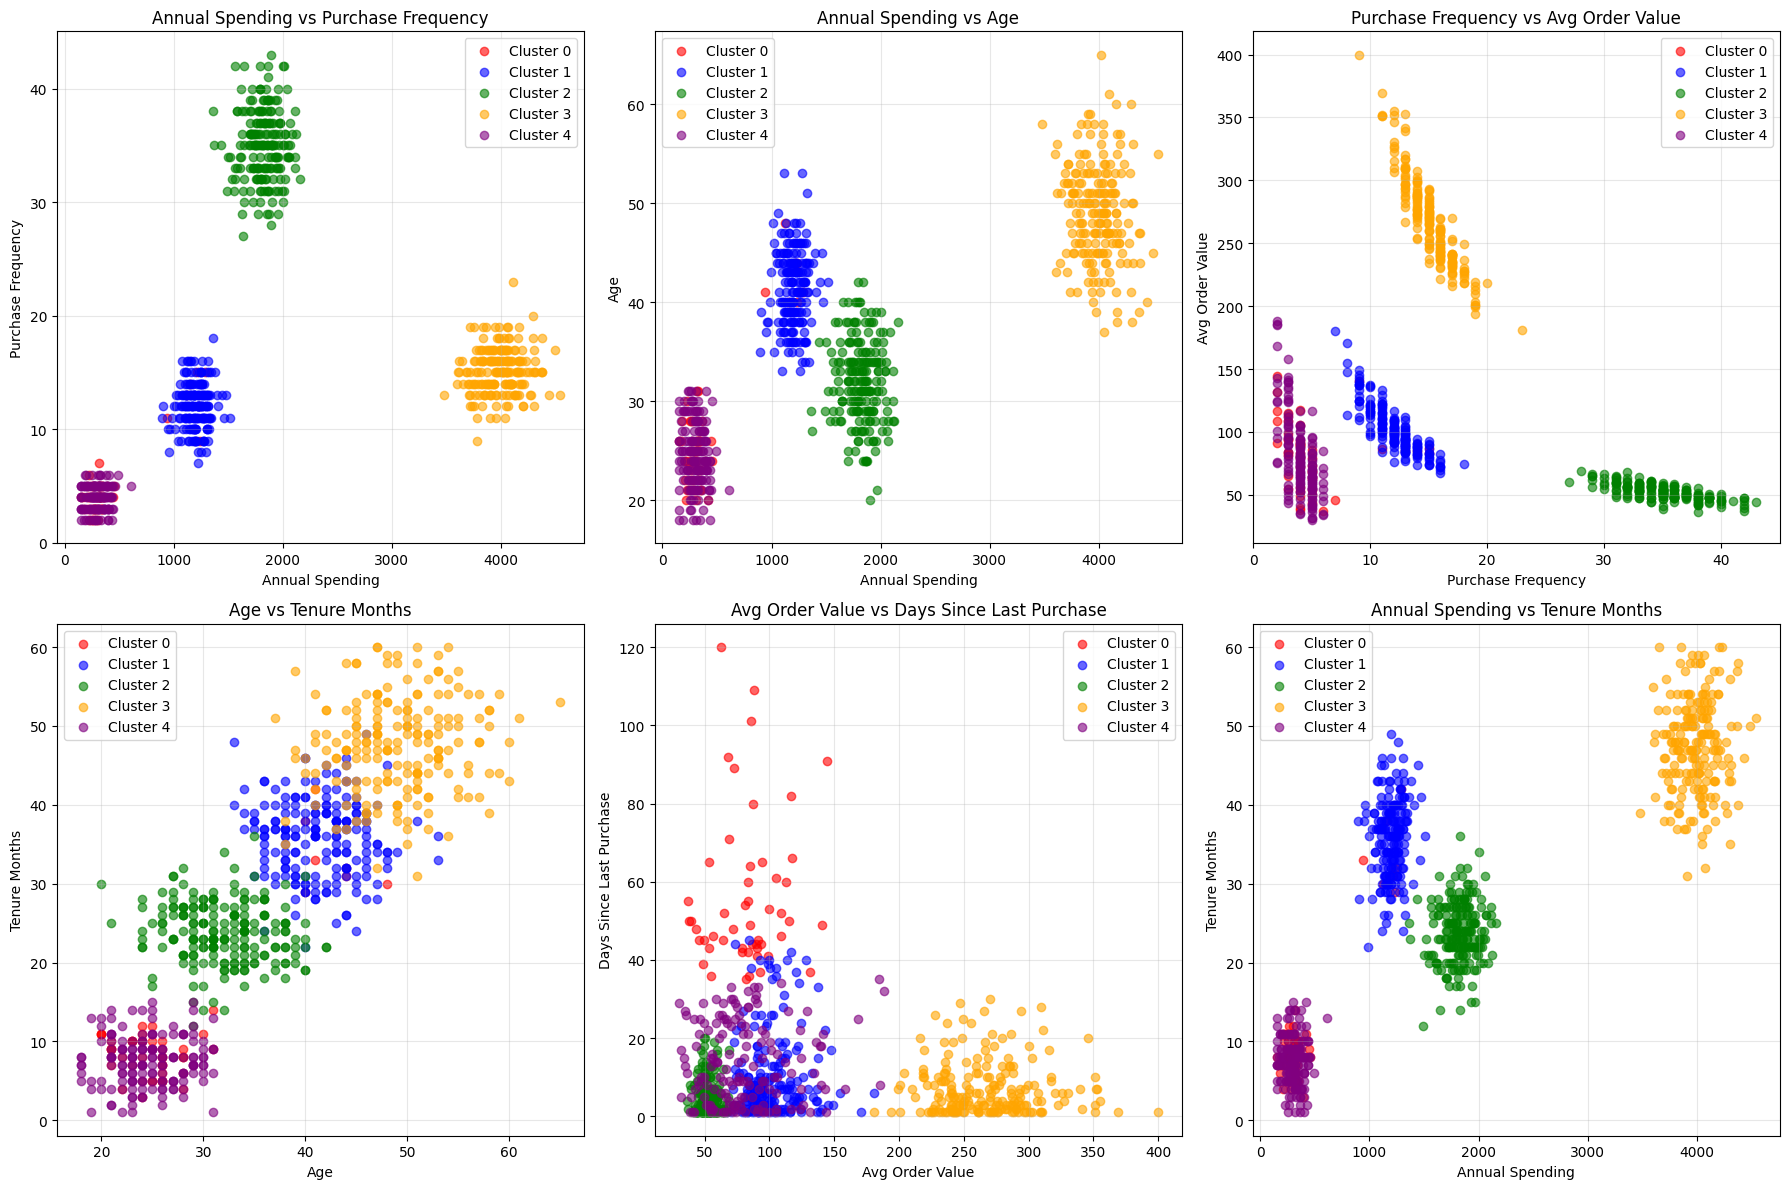

In [9]:
# Create visualizations to understand clusters better
plt.figure(figsize=(18, 12))

# 2D scatter plots of key feature combinations
feature_pairs = [
    ('annual_spending', 'purchase_frequency'),
    ('annual_spending', 'age'),
    ('purchase_frequency', 'avg_order_value'),
    ('age', 'tenure_months'),
    ('avg_order_value', 'days_since_last_purchase'),
    ('annual_spending', 'tenure_months')
]

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (x_feature, y_feature) in enumerate(feature_pairs):
    plt.subplot(2, 3, i+1)
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        plt.scatter(cluster_data[x_feature], cluster_data[y_feature], 
                   c=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.6)
    
    plt.xlabel(x_feature.replace('_', ' ').title())
    plt.ylabel(y_feature.replace('_', ' ').title())
    plt.title(f'{x_feature.replace("_", " ").title()} vs {y_feature.replace("_", " ").title()}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

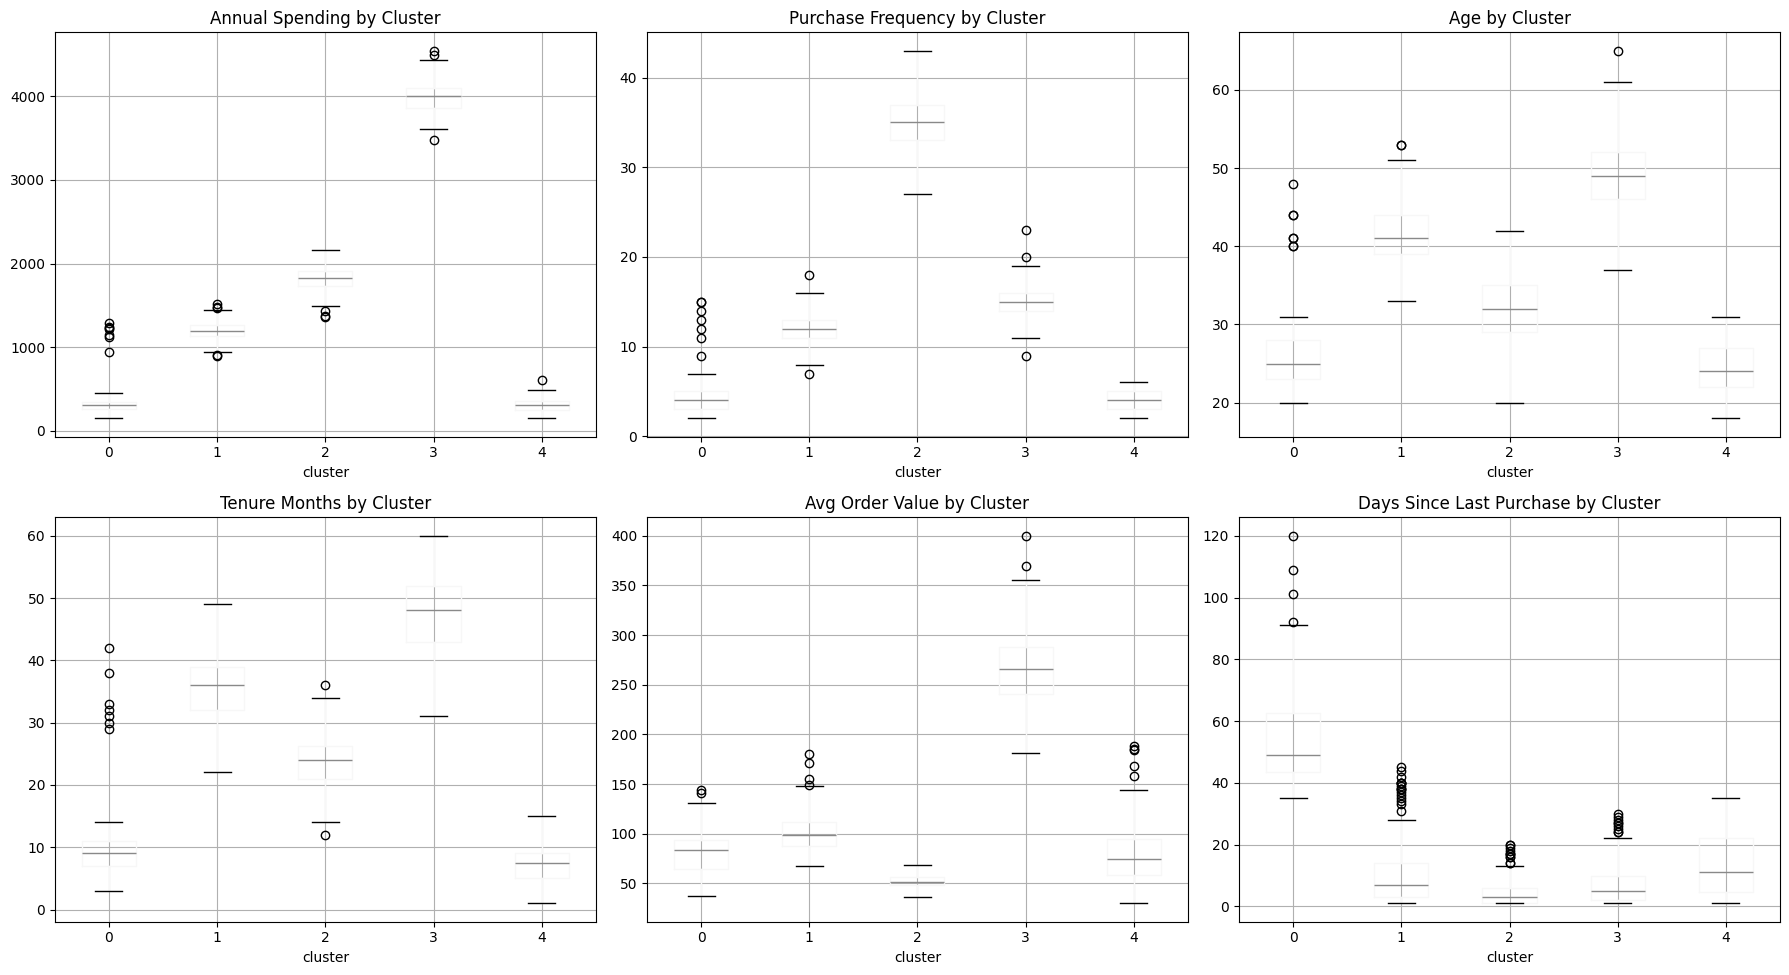

In [10]:
# Cluster comparison using box plots
plt.figure(figsize=(18, 10))

for i, feature in enumerate(clustering_features):
    plt.subplot(2, 3, i+1)
    df.boxplot(column=feature, by='cluster', ax=plt.gca())
    plt.title(f'{feature.replace("_", " ").title()} by Cluster')
    plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

## 9. Business Insights and Marketing Strategies

In [11]:
# Generate targeted marketing strategies for each cluster
print("CUSTOMER SEGMENTATION - TARGETED MARKETING STRATEGIES")
print("="*70)

for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    avg_spending = cluster_data['annual_spending'].mean()
    avg_frequency = cluster_data['purchase_frequency'].mean()
    avg_order_value = cluster_data['avg_order_value'].mean()
    avg_tenure = cluster_data['tenure_months'].mean()
    avg_age = cluster_data['age'].mean()
    days_last_purchase = cluster_data['days_since_last_purchase'].mean()
    
    print(f"\nCluster {cluster_id} - {len(cluster_data)} customers ({len(cluster_data)/len(df)*100:.1f}%):")
    print("-" * 50)
    
    # Determine cluster characteristics and strategies
    if avg_spending >= 3500:
        cluster_name = "Ultra-Premium High-Value Customers"
        strategy = [
            "- Offer exclusive ultra-VIP membership programs",
            "- Provide personal shopping concierge services",
            "- Early access to luxury and limited edition products",
            "- Premium white-glove customer service and support",
            "- Invite to exclusive high-end events and experiences",
            "- Personalized investment-grade product recommendations"
        ]
    elif avg_frequency >= 30:
        cluster_name = "Hyper-Active Frequent Shoppers"
        strategy = [
            "- Implement tiered loyalty rewards for ultra-frequent purchases",
            "- Offer substantial bulk purchase discounts and wholesale pricing",
            "- Provide subscription services with automatic replenishment",
            "- Create exclusive frequent buyer communities and forums",
            "- Develop referral programs with attractive incentives",
            "- Offer priority customer service and expedited shipping"
        ]
    elif avg_spending >= 1500 and avg_frequency >= 15:
        cluster_name = "High-Engagement Valuable Customers"
        strategy = [
            "- Balance frequency and value optimization programs",
            "- Cross-sell premium product lines and accessories",
            "- Provide personalized product recommendations",
            "- Offer exclusive member pricing and early access",
            "- Create targeted seasonal and holiday campaigns",
            "- Implement graduated loyalty tiers with increasing benefits"
        ]
    elif avg_spending >= 800:
        cluster_name = "Moderate-Value Stable Customers"
        strategy = [
            "- Focus on increasing purchase frequency through incentives",
            "- Provide educational content about product categories",
            "- Send targeted promotional offers and seasonal discounts",
            "- Create product bundle deals to increase order value",
            "- Implement re-engagement campaigns for inactive periods",
            "- Offer flexible payment options and financing"
        ]
    elif days_last_purchase >= 40:
        cluster_name = "At-Risk Low-Engagement Customers"
        strategy = [
            "- Launch urgent re-engagement campaigns with strong incentives",
            "- Provide significant discounts and promotional offers",
            "- Send personalized 'we miss you' communications",
            "- Offer customer service outreach to address concerns",
            "- Create special comeback offers and welcome-back programs",
            "- Focus on customer retention rather than acquisition"
        ]
    else:
        cluster_name = "Budget-Conscious Price-Sensitive Customers"
        strategy = [
            "- Focus on value-oriented promotions and discounts",
            "- Highlight budget-friendly product lines and alternatives",
            "- Provide educational content about product value and benefits",
            "- Offer flexible payment plans and financing options",
            "- Create entry-level product recommendations and starter packages",
            "- Implement win-back campaigns with attractive pricing"
        ]
    
    print(f"Segment Name: {cluster_name}")
    print(f"Key Metrics:")
    print(f"  - Avg Annual Spending: ${avg_spending:.2f}")
    print(f"  - Avg Purchase Frequency: {avg_frequency:.1f} times/year")
    print(f"  - Avg Order Value: ${avg_order_value:.2f}")
    print(f"  - Avg Age: {avg_age:.1f} years")
    print(f"  - Avg Tenure: {avg_tenure:.1f} months")
    print(f"  - Days Since Last Purchase: {days_last_purchase:.1f} days")
    print(f"\nRecommended Marketing Strategies:")
    for s in strategy:
        print(f"  {s}")

CUSTOMER SEGMENTATION - TARGETED MARKETING STRATEGIES

Cluster 0 - 51 customers (6.4%):
--------------------------------------------------
Segment Name: At-Risk Low-Engagement Customers
Key Metrics:
  - Avg Annual Spending: $414.56
  - Avg Purchase Frequency: 5.1 times/year
  - Avg Order Value: $82.49
  - Avg Age: 27.1 years
  - Avg Tenure: 11.8 months
  - Days Since Last Purchase: 56.1 days

Recommended Marketing Strategies:
  - Launch urgent re-engagement campaigns with strong incentives
  - Provide significant discounts and promotional offers
  - Send personalized 'we miss you' communications
  - Offer customer service outreach to address concerns
  - Create special comeback offers and welcome-back programs
  - Focus on customer retention rather than acquisition

Cluster 1 - 193 customers (24.1%):
--------------------------------------------------
Segment Name: Moderate-Value Stable Customers
Key Metrics:
  - Avg Annual Spending: $1199.80
  - Avg Purchase Frequency: 12.1 times/year


## 10. Save Results and Export

In [12]:
# Create output directory
import os
output_dir = 'p3_artifacts'
os.makedirs(output_dir, exist_ok=True)

# Save cluster assignments to CSV
output_file = f'{output_dir}/customer_segments.csv'
df.to_csv(output_file, index=False)
print(f"Customer segments saved to: {output_file}")

# Create a summary report
summary_stats = df.groupby('cluster').agg({
    'annual_spending': ['count', 'mean', 'std'],
    'purchase_frequency': 'mean',
    'age': 'mean',
    'avg_order_value': 'mean'
}).round(2)

summary_stats.to_csv(f'{output_dir}/cluster_summary.csv')
print(f"Cluster summary saved to: {output_dir}/cluster_summary.csv")

print(f"\nSegmentation completed successfully!")
print(f"Total customers segmented: {len(df)}")
print(f"Number of clusters: {optimal_k}")
print(f"Final silhouette score: {silhouette_score(X_scaled, cluster_labels):.3f}")

Customer segments saved to: p3_artifacts/customer_segments.csv
Cluster summary saved to: p3_artifacts/cluster_summary.csv

Segmentation completed successfully!
Total customers segmented: 800
Number of clusters: 5
Final silhouette score: 0.591


## 11. Summary and Analysis

#### Clustering Performance Assessment

**Silhouette Score Analysis**:
- **Final Score: 0.591** - This represents **REASONABLE clustering performance**
- Silhouette score interpretation: 0.7-1.0 (strong), 0.5-0.7 (reasonable), 0.25-0.5 (weak), <0.25 (poor)
- Indicates decent cluster separation with some overlap

**K-Selection Findings**:
- **Optimal K=5** determined by elbow method and silhouette analysis
- **Algorithmic disagreement** with synthetic design assumptions
- Well-defined peak at K=5 suggests legitimate cluster structure

#### Design vs. Reality Discrepancy

- **Intended Design**: 4 distinct segments with equal sizes (200 customers each)
- **Algorithmic Result**: 5 clusters with uneven distribution
- **Algorithm found patterns we didn't explicitly design** - one of our segments likely had internal structure
- Algorithm split one of our intended segments (0 and 4)

#### Synthetic Data Performance

** Limitations**:
- **Synthetic data** - patterns are artificially generated
- **No real customer behaviors** represented in analysis
- **Performance only reflects our programmed patterns**

#### Algorithmic Insights vs. Design Intentions

**Cluster Analysis** (K=5 results):
- **Cluster 0**: 51 customers (6.4%) - $415 spending, very late purchases (56 days)
- **Cluster 1**: 193 customers (24.1%) - $1200 spending, recent activity (10 days)  
- **Cluster 2**: 200 customers (25.0%) - $1821 spending, very recent (5 days)
- **Cluster 3**: 200 customers (25.0%) - $3992 spending, recent (7 days)
- **Cluster 4**: 156 customers (19.5%) - $302 spending, moderate activity (14 days)

**Algorithm's "Discovery"**:
- **Split budget segment** into two clusters (0 and 4) based on purchase recency
- **Maintained other segments** roughly as designed
- **Found meaningful sub-patterns** we didn't explicitly program

### Conclusion

This analysis demonstrates **reasonable clustering performance** (0.591 silhouette score). The algorithm's ability to find 5 clusters when we designed 4 shows pattern recognition beyond inital assumptions.